# Prognoser med LSTM for FPL

## Table of Contents

- [Preamble](#0:-Preamble)
- [0.2: Bruker inndata](#0.2:-Bruker-inndata)
- [Målvakter](#1:-Målvakter)
- [Forsvarsspillere](#2:-Forsvarsspillere)
- [Midtbanespillere](#3:-Midtbanespillere)
- [Angrepsspillere](#4:-Angrepsspillere)
- [Eksporter prognoser](#Eksporter)

## 0: Preamble

In [7]:
rm(list = ls(all = TRUE))

## 0: Preamble ----
#install.packages("glmnet");install.packages("")
library(keras3)
library(tidyverse)
library(slider)
#install_keras()
#library(tensorflow)
library(glmnet)

op_convert_to_tensor("hello")

tf.Tensor(b'hello', shape=(), dtype=string)

## 0.2: Bruker inndata

In [8]:
epoker <- 2
vindu <- 4

## 0.3: Hent data

In [9]:
df <- read_csv("https://raw.githubusercontent.com/Nysgjerrigper/test/refs/heads/main/Datasett/Ekstra%20kolonner%2C%20stigende%20GW%2C%20alle%20tre%20sesonger(22-24)%2C%20heltall.csv")
alternativsammensatt <- df

Rows: 76472 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, position, team, opponent_team
dbl  (39): xP, assists, bonus, bps, clean_sheets, creativity, expected_assis...
lgl   (1): was_home
dttm  (1): kickoff_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
#----------------------------
# 0.1: Oppdeling etter posisjon
#----------------------------
gk <- alternativsammensatt |>
  filter(position == "GK")

def <- alternativsammensatt |>
  filter(position == "DEF")

mid <- alternativsammensatt |>
  filter(position == "MID")

fwd <- alternativsammensatt |>
  filter(position == "FWD")

posliste <- list(gk = gk, def = def, mid = mid, fwd = fwd)
lapply(posliste, head, n = 1);lapply(posliste, tail, n = 1)
str(gk)

unscaled_gk <- gk
unscaled_def <- def
unscaled_mid <- mid
unscaled_fwd <- fwd

name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsdale,GK,Arsenal,3.6,0,0,25,1,0,0,⋯,0,50,FALSE,0,1,5,8,1,0,254
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Anselmino,DEF,Chelsea,1.8,0,0,0,0,0,0,⋯,0,40,FALSE,0,101,1,5,7,0,1
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsey,MID,Burnley,1.2,0,0,3,0,1,0.01,⋯,51,50,TRUE,0,41,6,2,6,1,359
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zack Steffen,GK,Man City,0,0,0,0,0,0,0,⋯,154,39,TRUE,0,76,1327,23,16,1,76382
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zak Sturge,DEF,Chelsea,0,0,0,0,0,0,0,⋯,16,40,TRUE,0,76,1329,3,7,1,76396
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zidane Iqbal,MID,Man United,0,0,0,0,0,0,0,⋯,119,42,TRUE,0,38,1331,10,17,1,76472
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


spc_tbl_ [8,328 × 45] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ name                      : chr [1:8328] "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" ...
 $ position                  : chr [1:8328] "GK" "GK" "GK" "GK" ...
 $ team                      : chr [1:8328] "Arsenal" "Arsenal" "Arsenal" "Arsenal" ...
 $ xP                        : num [1:8328] 3.6 4 5.3 4.8 3.9 2 3.5 3.3 2.5 5.3 ...
 $ assists                   : num [1:8328] 0 0 0 0 0 0 0 0 0 0 ...
 $ bonus                     : num [1:8328] 0 0 0 0 0 0 0 0 0 3 ...
 $ bps                       : num [1:8328] 25 10 20 12 13 14 24 12 15 32 ...
 $ clean_sheets              : num [1:8328] 1 0 1 0 0 0 1 0 0 1 ...
 $ creativity                : num [1:8328] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_assists          : num [1:8328] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goal_involvements: num [1:8328] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals            : num [1:8328] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals_conceded  

## 1: Målvakter

In [11]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded", "saves",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "penalties_saved", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded saves bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded penalties_saved value selected transfers_balance starts influence clean_sheets 
Kategoriske features: player_id tID oID hID 
Target variabel: total_points 
Ferdig

In [12]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(gk[[tar]], na.rm = TRUE)
sigma <- sd(gk[[tar]], na.rm = TRUE)

# Scale numerical features and target
gk <- gk %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

### 1.3 GK Build Rolling Windows

In [13]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [14]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------

# numW as data.matrix, tar as response variable
aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu


# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 
Selected features:  assists minutes bps expected_assists own_goals threat transfers_out expected_goals_conceded penalties_saved value selected transfers_balance clean_sheets 


In [15]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

cat("Kjørt")

Kjørt

In [16]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
set.seed(123)
idx <- sample(1:nSamp, size = floor(0.8 * nSamp))

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

cat("Kjørt")

Kjørt

In [18]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(gk$player_id)
num_teams     <- max(gk$tID)
num_opponents <- max(gk$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "Goalkeeper LSTM Model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = "mae",
  run_eagerly = TRUE
)
summary(model)

ERROR: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 1), dtype=int32, sparse=False, ragged=False, name=input_hID>',)
  • kwargs={'mask': 'None'}

In [ ]:
 #============================
# 8. Train the Model
#============================
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,
  batch_size = 32,
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  )
)

cat("Kjørt")

Kjørt

In [ ]:
#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_gk <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )


preds_gk <- preds_gk %>%
  left_join(unscaled_gk, by = "row_id") # Use unscaled_gk

# View the predictions table
glimpse(preds_gk)

preds_gk %>%
  filter(name == "Robert Sanchez")

Rows: 1,547
Columns: 49
$ row_id                        <dbl> 267, 269, 271, 272, 276, 279, 281, 285, …
$ predicted_total_points_scaled <dbl> 1.182358146, 0.614199698, 0.225941584, -…
$ actual_total_points_scaled    <dbl> 2.51484357, 0.55703873, 4.96209962, 0.06…
$ predicted_total_points        <dbl> 3.2775929, 2.1167858, 1.3235339, 0.59734…
$ actual_total_points           <dbl> 6, 2, 11, 1, 2, 1, 3, 2, 1, 2, 1, 0, 0, …
$ name                          <chr> "Aaron Ramsdale", "Aaron Ramsdale", "Aar…
$ position                      <chr> "GK", "GK", "GK", "GK", "GK", "GK", "GK"…
$ team                          <chr> "Arsenal", "Arsenal", "Arsenal", "Arsena…
$ xP                            <dbl> 6.5, 3.0, 5.5, 5.1, 2.5, 4.2, 5.1, 2.8, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 24, 15, 36, 8, 14, 12, 13, 11, 18, 11, 1…
$ clean_sheets  

row_id,predicted_total_points_scaled,actual_total_points_scaled,predicted_total_points,actual_total_points,name,position,team,xP,assists,⋯,transfers_in,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63058,0.05006193,0.55703873,0.9641934,2,Robert Sanchez,GK,Brighton,3.0,0,⋯,78144,22275,46,FALSE,0,15,1085,24,5,0
63060,0.39181608,3.98319720,1.6624328,9,Robert Sanchez,GK,Brighton,9.0,0,⋯,144672,353532,46,FALSE,1,17,1085,21,5,0
63065,-0.05515195,3.49374599,0.7492304,8,Robert Sanchez,GK,Brighton,5.3,0,⋯,26972,50311,46,TRUE,0,22,1085,3,5,1
63072,0.32641160,-0.42186369,1.5288047,0,Robert Sanchez,GK,Brighton,0.5,0,⋯,24793,106846,46,FALSE,0,29,1085,3,5,0
63074,0.38657200,0.06758752,1.6517186,1,Robert Sanchez,GK,Brighton,0.2,0,⋯,3288,39187,45,FALSE,1,31,1085,7,5,0
63076,0.16691664,-0.42186369,1.2029398,0,Robert Sanchez,GK,Brighton,0.4,0,⋯,24196,52946,45,TRUE,0,34,1085,24,5,1
63080,0.23105980,-0.42186369,1.3339910,0,Robert Sanchez,GK,Brighton,0.0,0,⋯,7348,30073,45,FALSE,0,36,1085,18,5,0
63084,0.22780409,0.55703873,1.3273392,2,Robert Sanchez,GK,Chelsea,1.9,0,⋯,0,0,45,TRUE,0,39,1085,14,7,1
63085,1.09823811,0.55703873,3.1057269,2,Robert Sanchez,GK,Chelsea,2.0,0,⋯,82350,21130,45,FALSE,0,40,1085,23,7,0


## 10. Plots Evaluation Data

,epoch,value,metric,data
,<int>,<dbl>,<fct>,<fct>
1,1,0.8905894,loss,training
2,2,0.6858953,loss,training
3,3,0.6626580,loss,training
4,4,0.6567748,loss,training
5,5,0.6445440,loss,training
6,6,0.6353863,loss,training


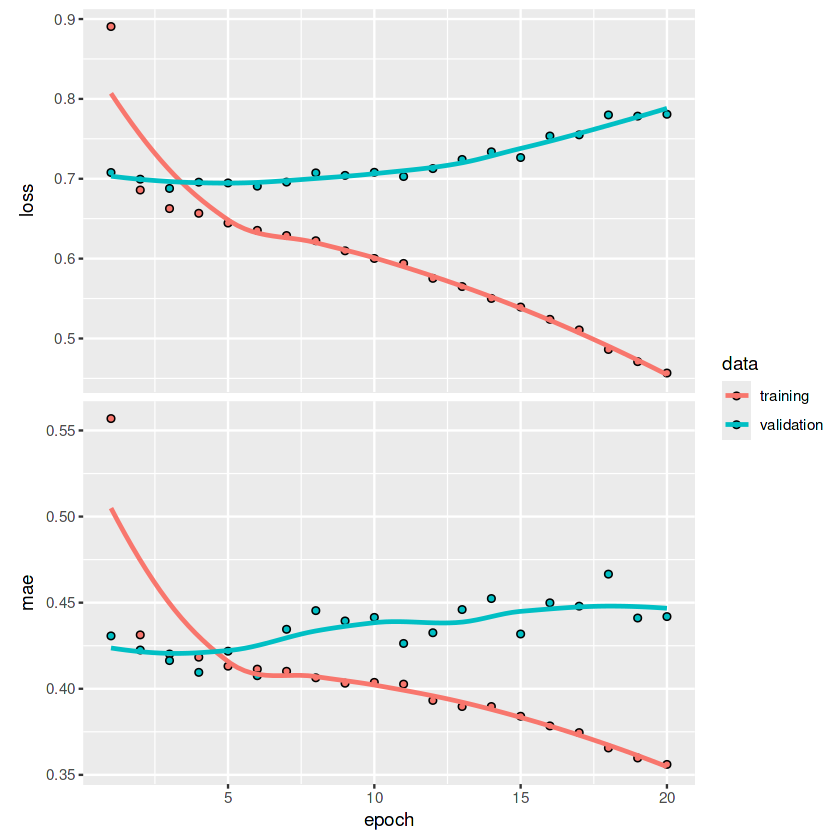

In [ ]:
plot(history)

history_df_gk <- as.data.frame(history)

head(history_df_gk)


# save_model_tf(model, filepath = "/kaggle/working/gkmodel_tf")

## 2: Forsvarsspillere

In [ ]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [ ]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(def[[tar]], na.rm = TRUE)
sigma <- sd(def[[tar]], na.rm = TRUE)

# Scale numerical features and target
def <- def %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)

cat("Kjørt")

Kjørt

In [ ]:
### 2.3 DEF Building rolling windows

In [ ]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [ ]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")

cat("Kjørt")

Windows with NA:  0 


Selected features:  assists creativity minutes bps expected_goal_involvements ict_index own_goals red_cards threat expected_goals_conceded value selected transfers_balance clean_sheets 


Kjørt

In [ ]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

In [ ]:

#============================
# 6. Split Data into Training and Validation Sets
#============================
set.seed(123)
idx <- sample(1:nSamp, size = floor(0.8 * nSamp))

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

In [ ]:

#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "def_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = "mae",
  run_eagerly = TRUE
)
summary(model)

Model: "def_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_3 (Embedding)  (None, 1, 20)     26640    ['input_player_id[0][0]']  
 embedding_4 (Embedding)  (None, 1, 20)     500      ['input_tID[0][0]']        
 embedding_5 (Embedding)  (None, 1, 20)     500      ['input_oID[0][0]']        
 lambda_1 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 4, 14)]   0        []                         
 fla

In [ ]:
#============================
# 8. Train the Model
#============================
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,
  batch_size = 32,
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  )
)

In [ ]:

#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_def <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_def <- preds_def %>%
  left_join(def, by = "row_id")

preds_def <- preds_def %>%
  left_join(unscaled_def, by = "row_id") # Use unscaled_def

# View the predictions table
glimpse(preds_def)

Rows: 4,752
Columns: 93
$ row_id                        <dbl> 52, 54, 58, 70, 75, 80, 81, 94, 105, 111…
$ predicted_total_points_scaled <dbl> 0.110442817, -0.175867036, -0.128717616,…
$ actual_total_points_scaled    <dbl> 0.44263480, 0.44263480, -0.01123475, -0.…
$ predicted_total_points        <dbl> 1.26808929, 0.63726959, 0.74115278, 2.09…
$ actual_total_points           <dbl> 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1…
$ name.x                        <chr> "Aaron Cresswell", "Aaron Cresswell", "A…
$ position.x                    <chr> "DEF", "DEF", "DEF", "DEF", "DEF", "DEF"…
$ team.x                        <chr> "West Ham", "West Ham", "West Ham", "Wes…
$ xP.x                          <dbl> 3.0, 0.0, 3.0, 0.6, 3.2, 1.6, 1.5, 0.8, …
$ assists.x                     <dbl> -0.143154, -0.143154, -0.143154, -0.1431…
$ bonus.x                       <dbl> -0.1846342, -0.1846342, -0.1846342, -0.1…
$ bps.x                         <dbl> 1.66038846, 1.99868297, 1.54762362, -0.2…
$ clean_sheets.x

## Eval plots

,epoch,value,metric,data
,<int>,<dbl>,<fct>,<fct>
1,1,0.9232127,loss,training
2,2,0.8319616,loss,training
3,3,0.8163986,loss,training
4,4,0.8038579,loss,training
5,5,0.7919406,loss,training
6,6,0.7804251,loss,training


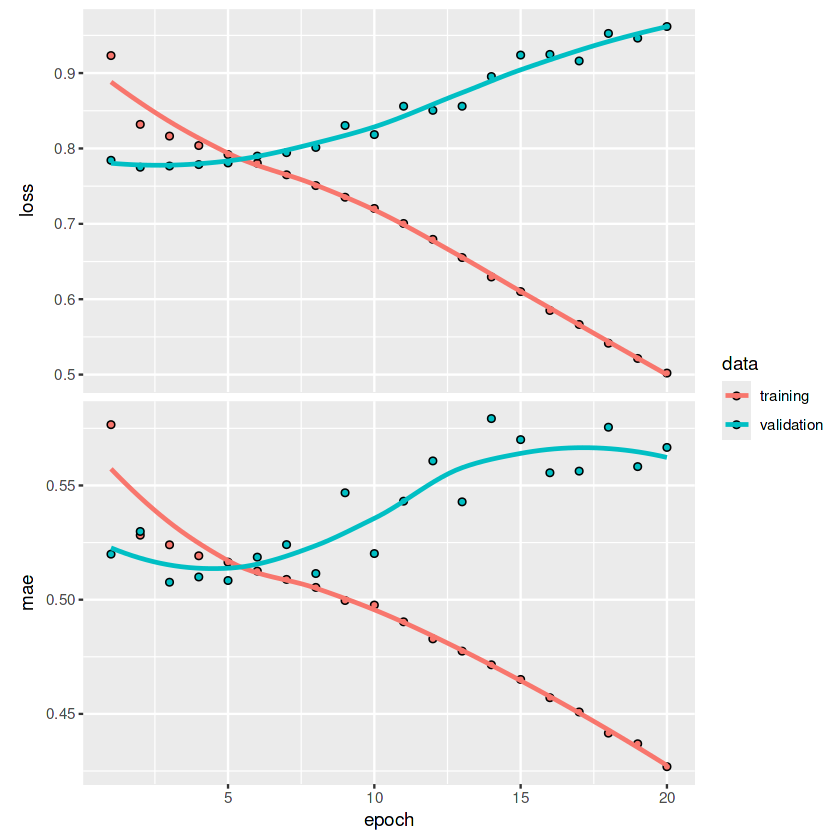

In [ ]:
plot(history)

history_df_def <- as.data.frame(history)

head(history_df_def)


# save_model_tf(model, filepath = "/kaggle/working/gkmodel_tf")

## 3: Midtbanespillere

In [ ]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [ ]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(mid[[tar]], na.rm = TRUE)
sigma <- sd(mid[[tar]], na.rm = TRUE)

# Scale numerical features and target
mid <- mid %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

### 3.3 MID Building Rolling Windows

In [ ]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [ ]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 


Selected features:  assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected starts influence clean_sheets 


In [ ]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

In [ ]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
set.seed(123)
idx <- sample(1:nSamp, size = floor(0.8 * nSamp))

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

In [ ]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "mid_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = "mae",
  run_eagerly = TRUE
)
summary(model)

Model: "mid_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_6 (Embedding)  (None, 1, 20)     26640    ['input_player_id[0][0]']  
 embedding_7 (Embedding)  (None, 1, 20)     500      ['input_tID[0][0]']        
 embedding_8 (Embedding)  (None, 1, 20)     500      ['input_oID[0][0]']        
 lambda_2 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 4, 21)]   0        []                         
 fla

In [ ]:
#============================
# 8. Train the Model
#============================
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,
  batch_size = 32,
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  )
)

cat("Kjørt")

Kjørt

In [ ]:

#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_mid <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_mid <- preds_mid %>%
  left_join(mid, by = "row_id")

preds_mid <- preds_mid %>%
  left_join(unscaled_mid, by = "row_id") # Use unscaled_mid

# View the predictions table
glimpse(preds_mid)

Rows: 6,215
Columns: 93
$ row_id                        <dbl> 368, 374, 387, 391, 505, 506, 511, 524, …
$ predicted_total_points_scaled <dbl> -0.43300977, -0.29669473, -0.33627793, -…
$ actual_total_points_scaled    <dbl> -0.51947022, -0.51947022, -0.51947022, -…
$ predicted_total_points        <dbl> 0.20539690, 0.52922926, 0.43519472, 0.32…
$ actual_total_points           <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 9, 1…
$ name.x                        <chr> "Aaron Ramsey", "Aaron Ramsey", "Aaron R…
$ position.x                    <chr> "MID", "MID", "MID", "MID", "MID", "MID"…
$ team.x                        <chr> "Burnley", "Burnley", "Burnley", "Burnle…
$ xP.x                          <dbl> -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1,…
$ assists.x                     <dbl> -0.2126918, -0.2126918, -0.2126918, -0.2…
$ bonus.x                       <dbl> -0.1926378, -0.1926378, -0.1926378, -0.1…
$ bps.x                         <dbl> -0.5514290, -0.5514290, -0.5514290, -0.5…
$ clean_sheets.x

## Eval plots mid

,epoch,value,metric,data
,<int>,<dbl>,<fct>,<fct>
1,1,0.8391034,loss,training
2,2,0.7498694,loss,training
3,3,0.7358479,loss,training
4,4,0.7253312,loss,training
5,5,0.7121992,loss,training
6,6,0.6975315,loss,training


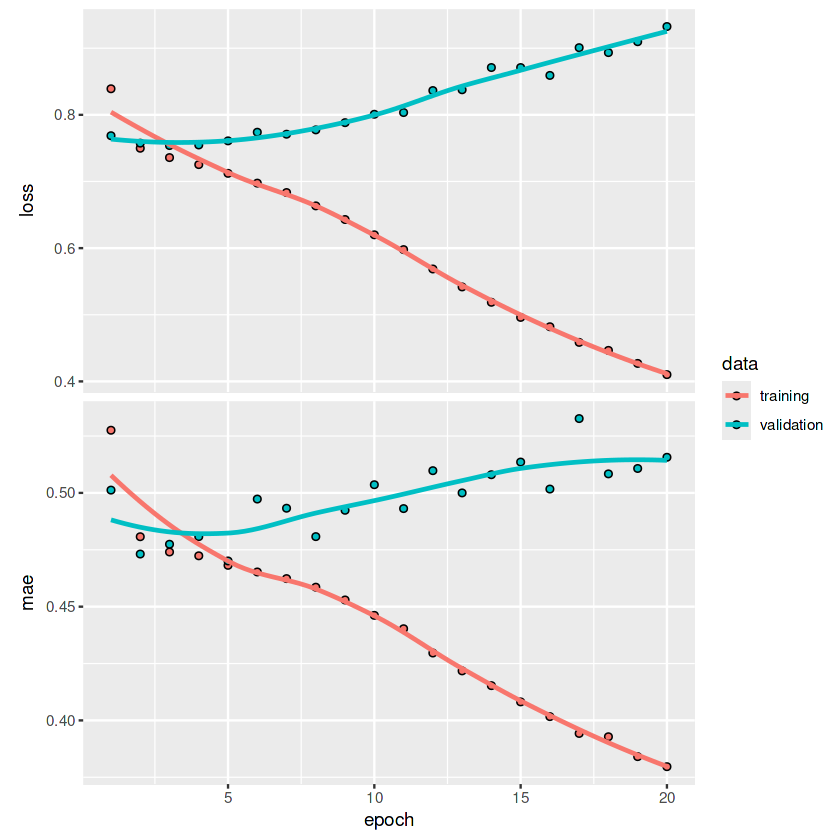

In [ ]:
plot(history)

history_df_mid <- as.data.frame(history)

head(history_df_mid)


# save_model_tf(model, filepath = "/kaggle/working/gkmodel_tf")

## 4: Angrepsspillere

In [ ]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [ ]:
# numF, catF og tar variablene brukes på nytt
# Compute and store the mean and standard deviation for the target variable
mu <- mean(fwd[[tar]], na.rm = TRUE)
sigma <- sd(fwd[[tar]], na.rm = TRUE)

# Scale numerical features and target
fwd <- fwd %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

### FWD Building rolling windows

In [ ]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [ ]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()

numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 


Selected features:  creativity minutes bps own_goals transfers_out yellow_cards expected_goals_conceded value selected 


In [ ]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

In [ ]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
set.seed(123)
idx <- sample(1:nSamp, size = floor(0.8 * nSamp))

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

In [ ]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(fwd$player_id)
num_teams     <- max(fwd$tID)
num_opponents <- max(fwd$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "fwd_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = "mae",
  run_eagerly = TRUE
)
summary(model)

Model: "fwd_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_9 (Embedding)  (None, 1, 20)     26620    ['input_player_id[0][0]']  
 embedding_10 (Embedding)  (None, 1, 20)    500      ['input_tID[0][0]']        
 embedding_11 (Embedding)  (None, 1, 20)    500      ['input_oID[0][0]']        
 lambda_3 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 4, 9)]    0        []                         
 fla

In [ ]:
#============================
# 8. Train the Model
#============================
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,
  batch_size = 32,
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  )
)

In [ ]:
#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_fwd <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

# Optionally, join additional information from gk (ensure gk has a "row_id" column)
preds_fwd <- preds_fwd %>%
  left_join(fwd, by = "row_id")

preds_fwd <- preds_fwd %>%
  left_join(unscaled_fwd, by = "row_id") # Use unscaled_mid

glimpse(preds_fwd)

Rows: 1,703
Columns: 93
$ row_id                        <dbl> 19, 21, 23, 33, 38, 42, 43, 686, 689, 69…
$ predicted_total_points_scaled <dbl> -0.51078224, -0.63822061, -0.65611356, -…
$ actual_total_points_scaled    <dbl> -0.4940901, -0.4940901, -0.4940901, -0.4…
$ predicted_total_points        <dbl> -0.04484031, -0.38717964, -0.43524573, -…
$ actual_total_points           <dbl> 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2…
$ name.x                        <chr> "Aaron Connolly", "Aaron Connolly", "Aar…
$ position.x                    <chr> "FWD", "FWD", "FWD", "FWD", "FWD", "FWD"…
$ team.x                        <chr> "Brighton", "Brighton", "Brighton", "Bri…
$ xP.x                          <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8, …
$ assists.x                     <dbl> -0.2007001, -0.2007001, -0.2007001, -0.2…
$ bonus.x                       <dbl> -0.2577078, -0.2577078, -0.2577078, -0.2…
$ bps.x                         <dbl> -0.40211964, -0.40211964, -0.40211964, -…
$ clean_sheets.x

## Eval Plots FWD

,epoch,value,metric,data
,<int>,<dbl>,<fct>,<fct>
1,1,0.9436846,loss,training
2,2,0.7728032,loss,training
3,3,0.7525263,loss,training
4,4,0.7393479,loss,training
5,5,0.7336037,loss,training
6,6,0.7288052,loss,training


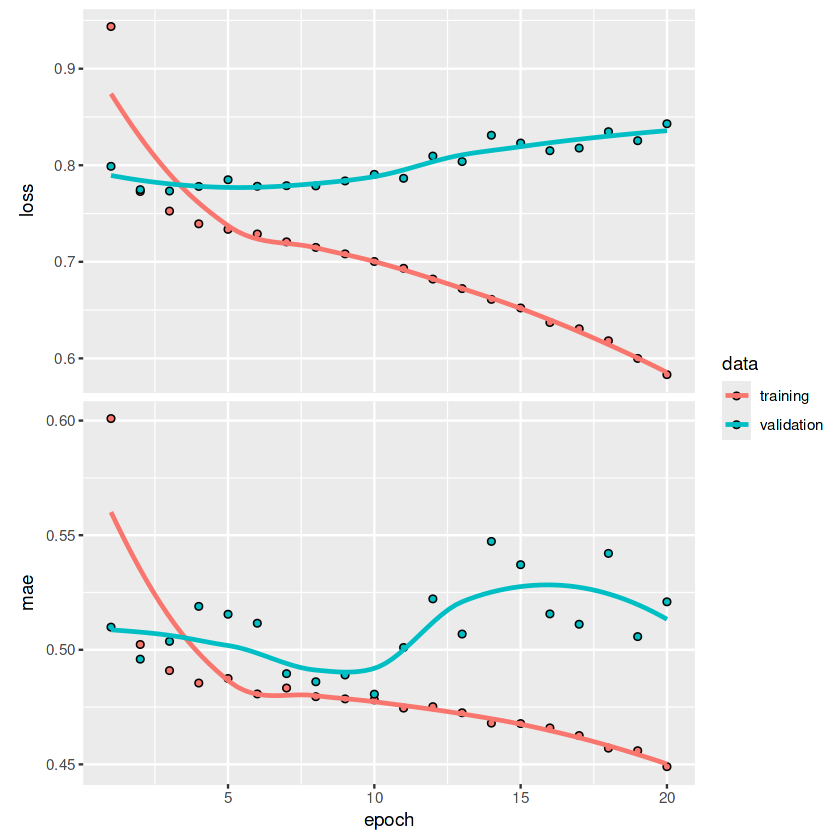

In [ ]:
plot(history)

history_df_fwd <- as.data.frame(history)

head(history_df_fwd)


# save_model_tf(model, filepath = "/kaggle/working/gkmodel_tf")

## Sett sammen tibbler

In [ ]:
print(preds_gk)
print(preds_def)
print(preds_mid)
print(preds_fwd)
#
forecastdf <- bind_rows(preds_gk,preds_def,preds_mid,preds_fwd) # FUNGERER IKKE, IKKE LIKT ANTALL RADER
cat("Kjørt")

# A tibble: 1,547 × 49
   row_id predicted_total_points…¹ actual_total_points_…² predicted_total_points
    <dbl>                    <dbl>                  <dbl>                  <dbl>
 1    267                   1.18                   2.51                    3.28 
 2    269                   0.614                  0.557                   2.12 
 3    271                   0.226                  4.96                    1.32 
 4    272                  -0.129                  0.0676                  0.597
 5    276                   0.170                  0.557                   1.21 
 6    279                  -0.230                  0.0676                  0.391
 7    281                   0.371                  1.05                    1.62 
 8    285                   1.42                   0.557                   3.76 
 9    286                   0.0131                 0.0676                  0.889
10    290                   0.526                  0.557                   1.94 
# ℹ 1

# A tibble: 4,752 × 93
   row_id predicted_total_points…¹ actual_total_points_…² predicted_total_points
    <dbl>                    <dbl>                  <dbl>                  <dbl>
 1     52                   0.110                  0.443                   1.27 
 2     54                  -0.176                  0.443                   0.637
 3     58                  -0.129                 -0.0112                  0.741
 4     70                   0.488                 -0.0112                  2.10 
 5     75                  -0.358                 -0.0112                  0.235
 6     80                   0.564                 -0.465                   2.27 
 7     81                   0.340                 -0.0112                  1.77 
 8     94                   0.108                 -0.465                   1.26 
 9    105                  -0.135                 -0.0112                  0.726
10    111                   0.0345                -0.465                   1.10 
# ℹ 4

# A tibble: 6,215 × 93
   row_id predicted_total_points…¹ actual_total_points_…² predicted_total_points
    <dbl>                    <dbl>                  <dbl>                  <dbl>
 1    368                  -0.433                 -0.519                   0.205
 2    374                  -0.297                 -0.519                   0.529
 3    387                  -0.336                 -0.519                   0.435
 4    391                  -0.383                 -0.519                   0.324
 5    505                   0.702                 -0.519                   2.90 
 6    506                   1.26                  -0.519                   4.23 
 7    511                  -0.228                 -0.519                   0.693
 8    524                   0.456                 -0.0985                  2.32 
 9    532                   0.0829                -0.519                   1.43 
10    536                   1.69                   0.322                   5.25 
# ℹ 6

# A tibble: 1,703 × 93
   row_id predicted_total_points…¹ actual_total_points_…² predicted_total_points
    <dbl>                    <dbl>                  <dbl>                  <dbl>
 1     19                  -0.511                  -0.494                -0.0448
 2     21                  -0.638                  -0.494                -0.387 
 3     23                  -0.656                  -0.494                -0.435 
 4     33                  -0.655                  -0.494                -0.433 
 5     38                  -0.702                  -0.494                -0.560 
 6     42                  -0.595                  -0.494                -0.271 
 7     43                  -0.429                  -0.494                 0.174 
 8    686                   0.0821                  0.250                 1.55  
 9    689                  -0.335                   0.250                 0.428 
10    692                  -0.167                  -0.494                 0.878 
# ℹ 1

Kjørt

## Eksporter

In [ ]:
#Eksporter fra Kaggle
write_csv(forecastdf, "Predicted.csv")
cat("Filen er lagret")

Filen er lagret